In [129]:
import os
import numpy as np
import pandas as pd
from utils.helper_functions import calculate_cbtmin, calculate_sleep_onset, calculate_sleep_duration

In [130]:
save_path = f"data/chang14_selected_light_sensitivity_parameters"
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [131]:
selected_parameters_early = pd.read_csv('data/light_sensitivity_parameter_exploration/early_light_selected_light_sensitivity_parameters.csv')
selected_parameters_late = pd.read_csv('data/light_sensitivity_parameter_exploration/late_light_selected_light_sensitivity_parameters.csv')
selected_parameters_options = [selected_parameters_early, selected_parameters_late]

In [132]:
time = np.load("data/light_schedules/time.npy")

In [133]:
DAILY_CONDITION_EBOOK_FIRST = [
    'None',
    'eBook', 'eBook', 'eBook', 'eBook', 'eBook',
    'None',
    'Book', 'Book', 'Book', 'Book', 'Book',
    'None',
]
DAILY_CONDITION_EBOOK_SECOND = [
    'None',
    'Book', 'Book', 'Book', 'Book', 'Book',
    'None',
    'eBook', 'eBook', 'eBook', 'eBook', 'eBook',
    'None',
]

DAILY_CONDITION_CHOICE = {
    'regular': ['None'] * 13,
    'chang14_ebook_first': DAILY_CONDITION_EBOOK_FIRST,
    'chang14_ebook_second': DAILY_CONDITION_EBOOK_SECOND,
    'chang14_high_ebook_first': DAILY_CONDITION_EBOOK_FIRST,
    'chang14_high_ebook_second': DAILY_CONDITION_EBOOK_SECOND,
    'realistic_ebook_first': DAILY_CONDITION_EBOOK_FIRST,
    'realistic_ebook_second': DAILY_CONDITION_EBOOK_SECOND,
}

In [134]:
light_conditions = [
    'early_light', 'late_light'
]

all_reading_conditions = [
    'chang14_ebook_first', 'chang14_ebook_second',
    'chang14_high_ebook_first', 'chang14_high_ebook_second',
    'realistic_ebook_first', 'realistic_ebook_second',
]
simulation_data_path = "data/chang14_selected_light_sensitivity_parameters"

simulation_features = pd.DataFrame()
for jdx, light_condition in enumerate(light_conditions):
    selected_parameters = selected_parameters_options[jdx]
    for idx in selected_parameters.index:
        data = np.load(f"{simulation_data_path}/{light_condition}/{light_condition}_chang14_simulation_{idx}.npz", 
                        allow_pickle=True)

        regular_sleep_onset = calculate_sleep_onset(time, data, 'regular')
        regular_cbtmin = calculate_cbtmin(time, data, 'regular')
        regular_sleep_duration = calculate_sleep_duration(time, data, 'regular')

        # Check if they have the same size
        min_length = min(len(regular_sleep_onset), len(regular_cbtmin))
        regular_sleep_onset = regular_sleep_onset[:min_length]
        regular_cbtmin = regular_cbtmin[:min_length]
        regular_sleep_duration = regular_sleep_duration[:min_length]

        normalized_sleep_onset = regular_sleep_onset - np.arange(1, len(regular_sleep_onset) + 1) * 24 + 24
        normalized_cbtmin = regular_cbtmin - np.arange(1, len(regular_cbtmin) + 1) * 24 + 24
        normalized_sleep_latency = (normalized_sleep_onset - 22.0) * 60
        normalized_sleep_latency[normalized_sleep_latency < 0] = 0.0

        daily_condition = DAILY_CONDITION_CHOICE['regular']


        data_subset = {
            'simulation_idx': idx,
            'day': np.arange(1, len(regular_cbtmin) + 1),
            'simulation_condition': 'regular',
            'sleep_onset': normalized_sleep_onset,
            'sleep_duration': regular_sleep_duration,
            'cbtmin': normalized_cbtmin,
            'sleep_latency_minutes': normalized_sleep_latency,
            'daily_condition': daily_condition[:min_length],
            'light_condition': light_condition,
        }

        simulation_features = pd.concat([simulation_features, pd.DataFrame(data_subset)])

        for reading_condition in all_reading_conditions:
            sleep_onset = calculate_sleep_onset(time, data, reading_condition)
            cbtmin = calculate_cbtmin(time, data, reading_condition)
            sleep_duration = calculate_sleep_duration(time, data, reading_condition,
                                                      light_condition=light_condition)

            min_length = min(len(sleep_onset), len(cbtmin), len(sleep_duration))
            sleep_onset = sleep_onset[:min_length]
            cbtmin = cbtmin[:min_length]
            sleep_duration = sleep_duration[:min_length]

            normalized_sleep_onset = sleep_onset - np.arange(1, len(sleep_onset) + 1) * 24 + 24
            normalized_cbtmin = cbtmin - np.arange(1, len(cbtmin) + 1) * 24 + 24
            normalized_sleep_latency = (normalized_sleep_onset - 22.0) * 60
            normalized_sleep_latency = (sleep_onset % 24 - 22.0) * 60
            normalized_sleep_latency[normalized_sleep_latency < 0] = 0.0

            daily_condition = DAILY_CONDITION_CHOICE[reading_condition]

            data_subset = {
                'simulation_idx': idx,
                'day': np.arange(1, len(cbtmin) + 1),
                'simulation_condition': reading_condition,
                'sleep_onset': normalized_sleep_onset,
                'sleep_duration': sleep_duration,
                'cbtmin': normalized_cbtmin,
                'sleep_latency_minutes': normalized_sleep_latency,
                'daily_condition': daily_condition[:min_length],
                'light_condition': light_condition,
            }
            simulation_features = pd.concat([simulation_features, pd.DataFrame(data_subset)])
    
simulation_features.to_csv(f"{save_path}/selected_light_sensitivity_parameters_simulation_features.csv",
                           index=False)

# Calculate phase shifts

In [135]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [136]:
light_conditions = [
    'early_light', 'late_light'
]

all_reading_conditions = [
    'chang14_ebook_first', 'chang14_ebook_second',
    'chang14_high_ebook_first', 'chang14_high_ebook_second',
    'realistic_ebook_first', 'realistic_ebook_second',
]
simulation_data_path = "data/chang14_selected_light_sensitivity_parameters"

phase_shifts = pd.DataFrame()
for jdx, light_condition in enumerate(light_conditions):
    selected_parameters = selected_parameters_options[jdx]
    for idx in selected_parameters.index:
        data = np.load(f"{simulation_data_path}/{light_condition}/{light_condition}_chang14_simulation_{idx}.npz", 
                        allow_pickle=True)

        parameters = selected_parameters.loc[idx]

        for reading_condition in all_reading_conditions:
            time = data['time']
            trajectory = data[f'{reading_condition}_trajectory_states']
            light = data[f'{reading_condition}_light']
            x = trajectory[:, 0]

            CP1_mask = (time <= 7 * 24 +  6) & (time >= 6 * 24  + 6)
            CP2_mask = (time <= 13 * 24 + 6) & (time >= 12 * 24 + 6)

            CP1_x = x[CP1_mask]
            CP2_x = x[CP2_mask]

            CP1_peak_idxs, _ = find_peaks(CP1_x, height=0.5)
            CP2_peak_idxs, _ = find_peaks(CP2_x, height=0.5)

            CP1_peak_idxs = CP1_peak_idxs[0] if len(CP1_peak_idxs) > 0 else np.array([])
            CP2_peak_idxs = CP2_peak_idxs[0] if len(CP2_peak_idxs) > 0 else np.array

            try: 
                CP1_peak = CP1_x[CP1_peak_idxs]
                CP2_peak = CP2_x[CP2_peak_idxs]
            except:
                # fig, ax = plt.subplots(2, 1, figsize=(4, 4))
                # ax[0].plot(relative_time, CP1_x)
                # ax[0].plot(relative_time, CP2_x)

                # ax[0].scatter(CP1_peak_time, CP1_peak, c='r')
                # ax[0].scatter(CP2_peak_time, CP2_peak, c='r')

                # ax[0].text(0, 0.5, f"Phase shift: {phase_shift:.2f}", transform=ax[0].transAxes)

                # ax[1].plot(relative_time, CP1_light)
                # fig.suptitle(f"Sim: {idx} - {light_condition} - {reading_condition}")
                # plt.show()
                # plt.close()
                continue


            relative_time = time[CP1_mask] - 6 * 24

            CP1_peak_time = relative_time[CP1_peak_idxs]
            CP2_peak_time = relative_time[CP2_peak_idxs]

            phase_shift = CP2_peak_time - CP1_peak_time if 'ebook_second' in reading_condition else CP1_peak_time - CP2_peak_time

            CP1_light = light[CP1_mask]

            schedule_condition = "_".join(reading_condition.split('_')[:-2])

            data_subset = {
                'simulation_idx': idx,
                'light_condition': light_condition,
                'schedule_condition': schedule_condition,
                'reading_condition': "_".join(reading_condition.split('_')[-2:]),
                'phase_shift': phase_shift,
                'p': parameters['p'],
                'k': parameters['k'],
                'tauc': parameters['tauc'], 
            }
            # concat with index
            phase_shifts = pd.concat([phase_shifts, pd.DataFrame(data_subset, index=[idx])])

            # print(f'sim idx: {idx} - {light_condition} - {reading_condition} - phase shift: {phase_shift}')


            # fig, ax = plt.subplots(2, 1, figsize=(4, 4))
            # ax[0].plot(relative_time, CP1_x)
            # ax[0].plot(relative_time, CP2_x)

            # ax[0].scatter(CP1_peak_time, CP1_peak, c='r')
            # ax[0].scatter(CP2_peak_time, CP2_peak, c='r')

            # ax[0].text(0, 0.5, f"Phase shift: {phase_shift:.2f}", transform=ax[0].transAxes)

            # ax[1].plot(relative_time, CP1_light)
            # fig.suptitle(f"Sim: {idx} - {light_condition} - {reading_condition}")
            # plt.show()
            # plt.close()

In [137]:
phase_shifts

,simulation_idx,light_condition,schedule_condition,reading_condition,phase_shift,p,k,tauc
0,0,early_light,chang14,ebook_first,1.105,0.5,0.4,23.8
0,0,early_light,chang14,ebook_second,0.475,0.5,0.4,23.8
0,0,early_light,chang14_high,ebook_first,0.955,0.5,0.4,23.8
0,0,early_light,chang14_high,ebook_second,0.385,0.5,0.4,23.8
0,0,early_light,realistic,ebook_first,0.490,0.5,0.4,23.8
...,...,...,...,...,...,...,...,...
124,124,late_light,chang14,ebook_second,-0.175,0.7,0.7,24.4
124,124,late_light,chang14_high,ebook_first,1.020,0.7,0.7,24.4
124,124,late_light,chang14_high,ebook_second,-0.295,0.7,0.7,24.4
124,124,late_light,realistic,ebook_first,0.865,0.7,0.7,24.4


In [33]:
import seaborn as sns

chang14


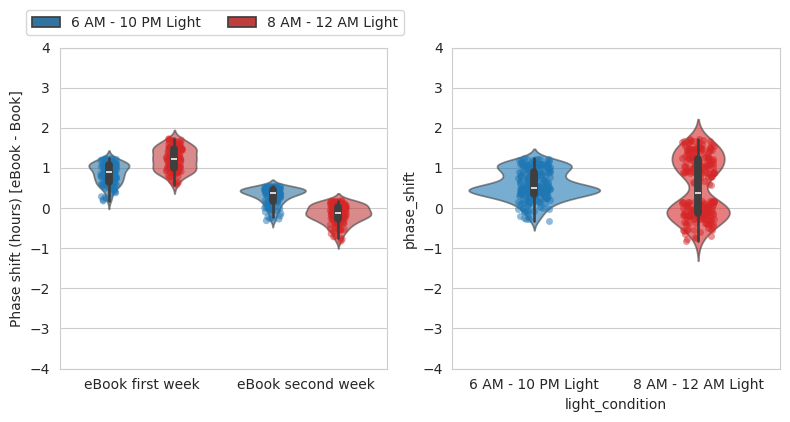

chang14_high


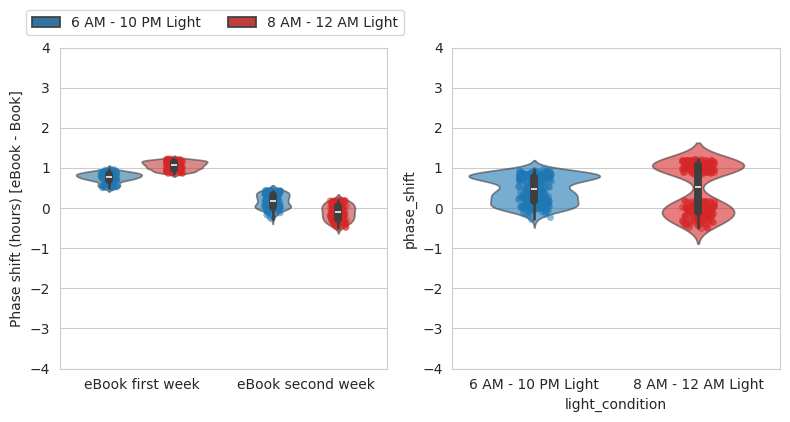

realistic


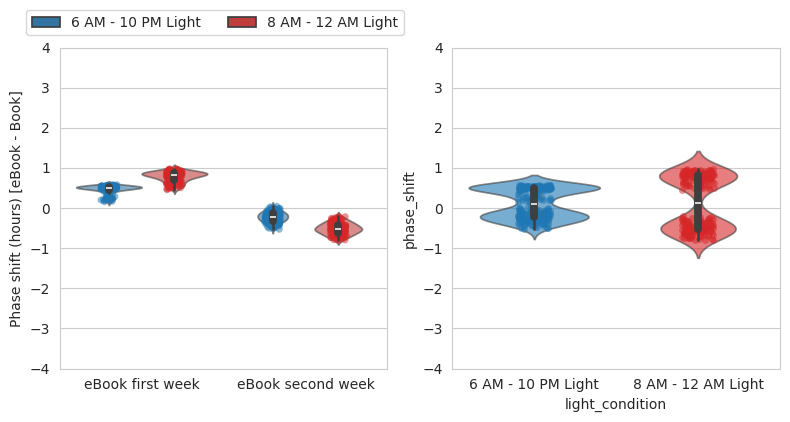

In [138]:
for schedule in phase_shifts['schedule_condition'].unique():
    plot_data = phase_shifts[phase_shifts['schedule_condition'] == schedule]
    # trim values larger than 4
    # plot_data = plot_data[(plot_data['phase_shift'] <= 3) & (plot_data['phase_shift'] >= -3)]

    print(schedule)
    # violin plot
    palette = {
        'early_light': 'tab:blue',
        'late_light': 'tab:red'
    }
    sns.set_style('whitegrid')
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    sns.violinplot(x='reading_condition', y='phase_shift', hue='light_condition', data=plot_data, ax=ax[0],
                    palette=palette)

    for violin  in ax[0].collections[::]:
        violin.set_alpha(0.6)

    sns.stripplot(x='reading_condition', y='phase_shift', hue='light_condition', data=plot_data, ax=ax[0], dodge=True, jitter=True,
                    alpha=0.5, zorder=1, legend=False, palette=palette)
    ax[0].set_ylabel('Phase shift (hours) [eBook - Book]')
    ax[0].set_xticks(range(len(plot_data['reading_condition'].unique())))
    ax[0].set_xticklabels(['eBook first week', 'eBook second week'])
    handles, labels = ax[0].get_legend_handles_labels()
    labels = ['6 AM - 10 PM Light', '8 AM - 12 AM Light']
    fig.legend(handles, labels, bbox_to_anchor=(0.275, 1.06), loc='upper center', ncol=2)
    ax[0].get_legend().remove()
    ax[0].set_xlabel('')
    ax[0].set_ylim(-4, 4)

    # ax 2 plot just separated by light condition
    sns.violinplot(x='light_condition', y='phase_shift', data=plot_data, ax=ax[1],
                   )
    # ax[1].set_ylabel('Phase shift (hours) [eBook - Book]')

    # make it transparent
    facecolors = ['tab:blue', 'tab:red']
    for idx, violin in enumerate(ax[1].collections[::]):
        violin.set_alpha(0.6)
        violin.set_facecolor(facecolors[idx])
    
    p = sns.stripplot(x='light_condition', y='phase_shift', data=plot_data, ax=ax[1], dodge=True, jitter=True,
                      alpha=0.5, zorder=1, legend=False, color='tab:blue')
    p.collections[3].set_facecolor('tab:red')

    ax[1].set_xticks(range(len(plot_data['light_condition'].unique())))
    ax[1].set_xticklabels(['6 AM - 10 PM Light', '8 AM - 12 AM Light'])

    # print median value
    # ax[1].text(0.525, 0.525, f"Median: {np.median(all_shifts) * 60:.1f} min", transform=ax[1].transAxes)
    ax[1].set_ylim(-4, 4)

    plt.tight_layout()
    plt.show()
    plt.close()

chang14 - early_light - ebook_first


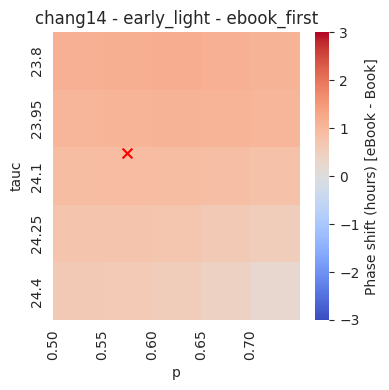

chang14 - early_light - ebook_second


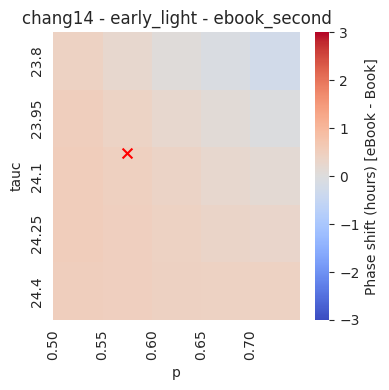

chang14 - late_light - ebook_first


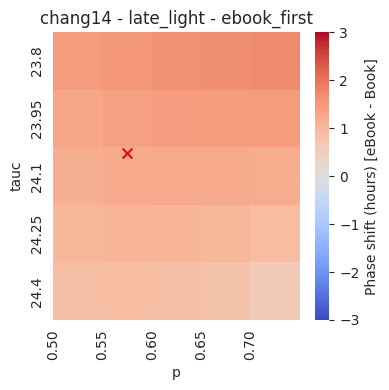

chang14 - late_light - ebook_second


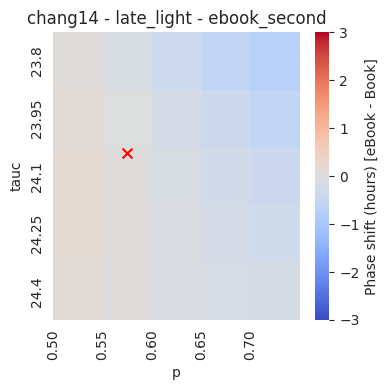

chang14_high - early_light - ebook_first


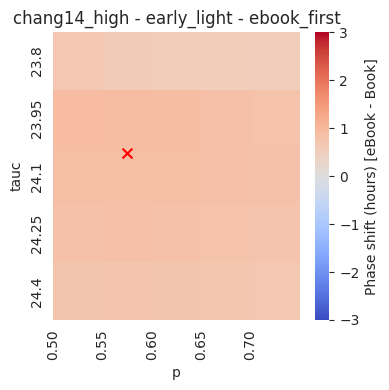

chang14_high - early_light - ebook_second


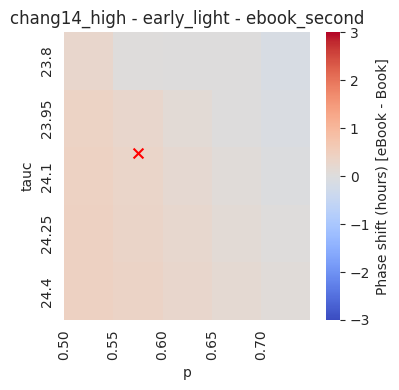

chang14_high - late_light - ebook_first


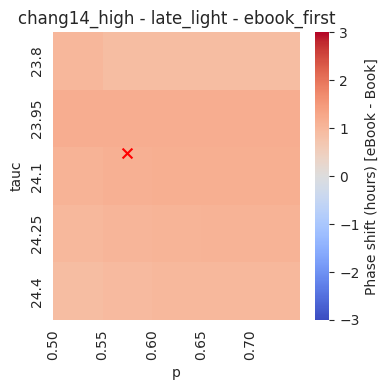

chang14_high - late_light - ebook_second


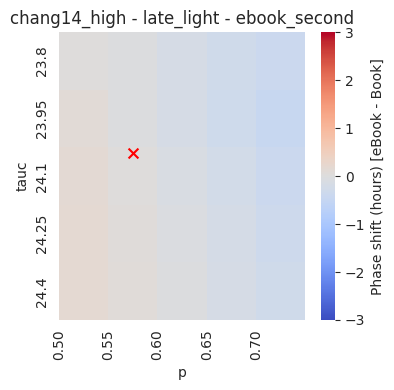

realistic - early_light - ebook_first


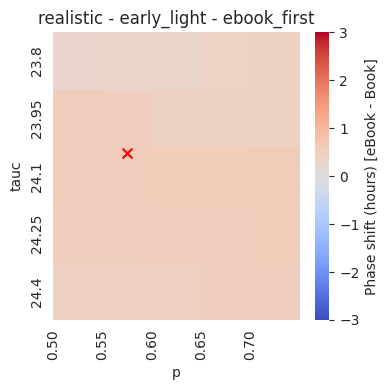

realistic - early_light - ebook_second


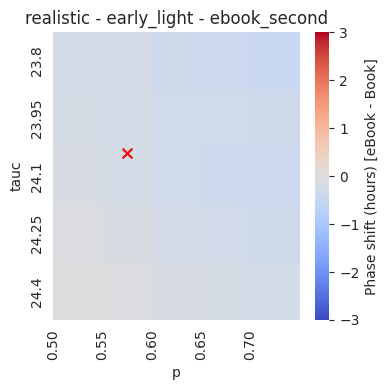

realistic - late_light - ebook_first


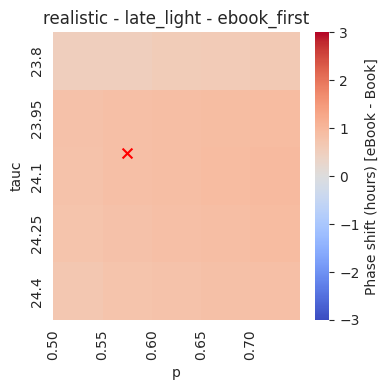

realistic - late_light - ebook_second


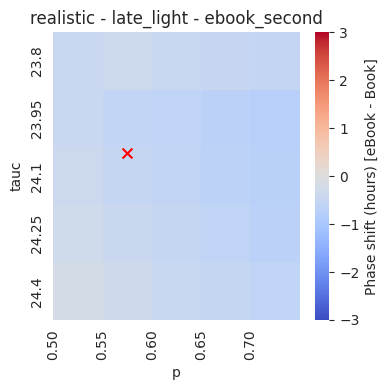

In [141]:
for schedule in phase_shifts['schedule_condition'].unique():
    plot_data = phase_shifts[phase_shifts['schedule_condition'] == schedule]
    for light_condition in plot_data['light_condition'].unique():
        light_data = plot_data[plot_data['light_condition'] == light_condition]
        for reading_condition in light_data['reading_condition'].unique():
            final_data = light_data[light_data['reading_condition'] == reading_condition]
            print(f"{schedule} - {light_condition} - {reading_condition}")
            # trim values larger than 3
            final_data = final_data[(final_data['phase_shift'] <= 4) & (final_data['phase_shift'] >= -4)]
            # sns.scatterplot(x='p', y='tauc', hue='phase_shift', data=final_data,
            #                 palette='coolwarm')
            # do a heatmap
            # group data by p and tauc and get the mean
            final_data = final_data[['k', 'p', 'tauc', 'phase_shift']].groupby(['p', 'tauc']).median().reset_index()

            fig, ax = plt.subplots(1, 1, figsize=(4, 4))
            sns.heatmap(final_data.pivot(index='tauc', columns='p', values='phase_shift'), cmap='coolwarm', ax=ax,
                        cbar_kws={'label': 'Phase shift (hours) [eBook - Book]'}, vmin=-3, vmax=3)
            ax.set_xlabel('p')
            ax.set_ylabel('tauc')
            ax.set_xticks(range(len(final_data['p'].unique())))
            ax.set_xticklabels([f"{p:.2f}" for p in final_data['p'].unique()])
            # add a point in the plot at x = 0.55 y = 24.2
            
            ax.scatter(1.5, 2.1, c='r', s=50, marker='x')
            plt.title(f"{schedule} - {light_condition} - {reading_condition}")

            plt.tight_layout()
            plt.show()
            plt.close()